In [2]:
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
# Отключаем все предупреждения
warnings.filterwarnings("ignore")
df = pd.read_csv('payments_data_set.csv')
# Display the first few rows of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8438 entries, 0 to 8437
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Дата оплаты                        8438 non-null   object 
 1   Сумма (тыс. руб)                   8438 non-null   float64
 2   День недели                        8438 non-null   int64  
 3   Номер рабочего дня в году          8438 non-null   int64  
 4   Номер недели                       8438 non-null   int64  
 5   Год                                8438 non-null   int64  
 6   Сумма платежей с начала недели     8438 non-null   float64
 7   прошлогодняя сумма на дату         5876 non-null   float64
 8   прошлогодняя сумма на день         7932 non-null   float64
 9   прошлогодняя недельная сумма       7958 non-null   float64
 10  Размер контрактуемых обязательств  8438 non-null   float64
 11  Курс доллара                       8434 non-null   float

In [3]:
import ta
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# Построение графика
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Дата оплаты'], y=df['Сумма (тыс. руб)'], mode='lines', name='VALUE'))
fig.update_layout(title='Визуализация платежей по дням', xaxis_title='Дата', yaxis_range=[0,25000000], yaxis_title='Значение')
fig.show()

In [7]:
# Построение графика
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Дата оплаты'], y=df['Размер контрактуемых обязательств']/1000, mode='lines', name='VALUE'))
fig.update_layout(title='Визуализация законтраткованных обязательств', xaxis_title='Дата', yaxis_range=[0,150000000], yaxis_title='Значение')
fig.show()

In [9]:
# Построение графика
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Дата оплаты'], y=df['Курс доллара'], mode='lines', name='VALUE'))
fig.update_layout(title='Динамика курса доллара', xaxis_title='Дата', yaxis_range=[0,200], yaxis_title='Значение')
fig.show()

In [10]:
# Построение графика
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Дата оплаты'], y=df['котировка Brent'], mode='lines', name='VALUE'))
fig.update_layout(title='Динамика цены на нефть марки Brent', xaxis_title='Дата', yaxis_range=[0,300], yaxis_title='Значение')
fig.show()

In [11]:
import pandas as pd

from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Сумма (тыс. руб)'])

# Вывод результатов теста
print('Статистика теста:', result[0])
print('p-значение:', result[1])
print('Критические значения:', result[4])

Статистика теста: -20.18200380043068
p-значение: 0.0
Критические значения: {'1%': np.float64(-3.4311264146614406), '5%': np.float64(-2.861883122031576), '10%': np.float64(-2.5669526389807076)}


Исходя из полученных результатов теста Дики-Фуллера, можно сделать следующие выводы:

    Статистика теста равна -20.182, что значительно ниже всех критических значений.
    P-значение равно 0.0, что меньше любого стандартного уровня значимости (например, 0.05 или 0.01).

Эти результаты позволяют отвергнуть нулевую гипотезу о наличии единичного корня в временном ряде «Сумма (тыс. руб)». Следовательно, можно считать, что временной ряд является стационарным.


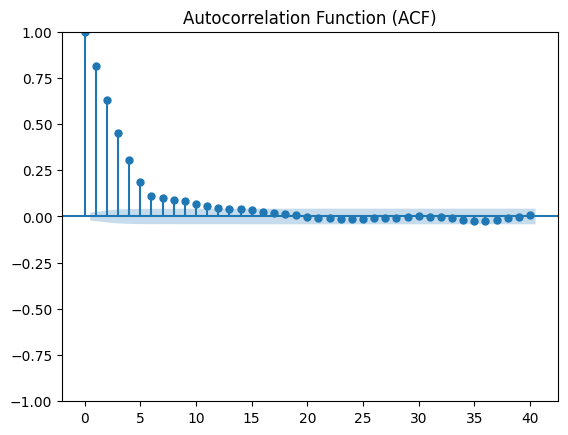

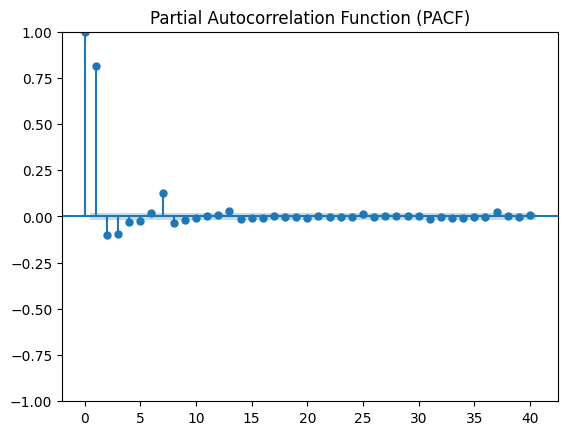

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Построение графика ACF
plot_acf(df['Сумма (тыс. руб)'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Построение графика PACF
plot_pacf(df['Сумма (тыс. руб)'], lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [14]:
from statsmodels.tsa.stattools import acf
# Вычисление ACF значений
acf_values, confint = acf(df['Сумма (тыс. руб)'], nlags=40, alpha=0.05)
# Определение порядка MA (q)
q = 0
for i in range(len(acf_values)):
    if abs(acf_values[i]) < confint[i][0]:  # Проверка на значимость
        q = i - 1  # Устанавливаем q на предыдущий лаг
        break

print(f"Определенный порядок MA (q): {q}")

Определенный порядок MA (q): 0


                               SARIMAX Results                                
Dep. Variable:       Сумма (тыс. руб)   No. Observations:                 8016
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -123148.894
Date:                Fri, 16 May 2025   AIC                         246303.787
Time:                        16:11:47   BIC                         246324.755
Sample:                             0   HQIC                        246310.963
                               - 8016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.861e+05   2.59e-11   3.42e+16      0.000    8.86e+05    8.86e+05
ar.L1          0.8083      0.002    460.154      0.000       0.805       0.812
sigma2      1.293e+12   4.08e-16   3.17e+27      0.0

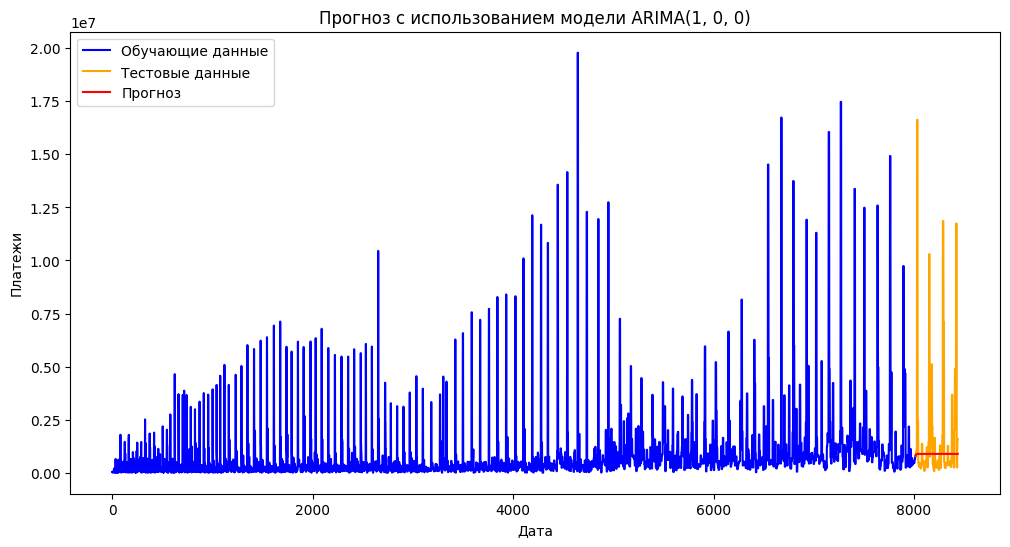

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Разделение данных на обучающий и тестовый наборы
train_size = int(len(df['Сумма (тыс. руб)']) * 0.95)
train, test = df['Сумма (тыс. руб)'][:train_size], df['Сумма (тыс. руб)'][train_size:]

# Обучение модели ARIMA с p=1, d=0, q=0

model = ARIMA(train, order=(1, 0, 0))
model_fit = model.fit()

# Вывод результатов
print(model_fit.summary())

# Прогнозирование на тестовом наборе
forecast = model_fit.forecast(steps=len(test))
# Оценка модели
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse}")


# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Обучающие данные', color='blue')
plt.plot(test.index, test, label='Тестовые данные', color='orange')
plt.plot(test.index, forecast, label='Прогноз', color='red')
plt.title('Прогноз с использованием модели ARIMA(1, 0, 0)')
plt.xlabel('Дата')
plt.ylabel('Платежи')
plt.legend()
plt.show()

In [18]:
print(round(forecast,2))

8016    809930.33
8017    824536.89
8018    836342.74
8019    845884.91
8020    853597.45
          ...    
8433    886108.33
8434    886108.33
8435    886108.33
8436    886108.33
8437    886108.33
Name: predicted_mean, Length: 422, dtype: float64


из-за отсутствия автокореляции, модель выдаёт усреднённое значение в качестве прогноза


                               SARIMAX Results                                
Dep. Variable:       Сумма (тыс. руб)   No. Observations:                 8016
Model:               SARIMAX(1, 0, 0)   Log Likelihood             -123222.167
Date:                Fri, 16 May 2025   AIC                         246448.334
Time:                        16:13:34   BIC                         246462.312
Sample:                             0   HQIC                        246453.118
                               - 8016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8416      0.002    504.173      0.000       0.838       0.845
sigma2      1.317e+12   3.38e-16    3.9e+27      0.000    1.32e+12    1.32e+12
Ljung-Box (L1) (Q):                  27.29   Jarque-

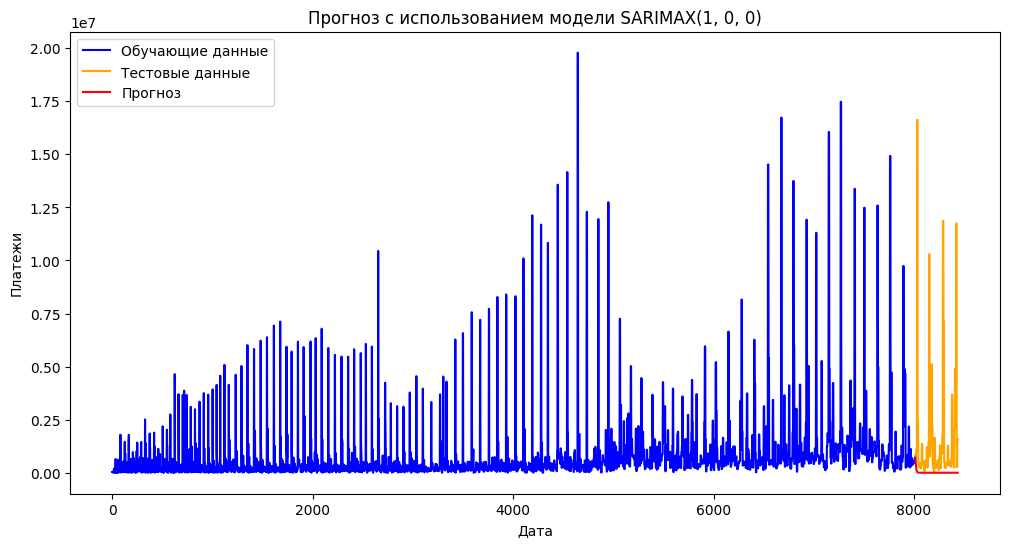

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Разделение данных на обучающий и тестовый наборы
train_size = int(len(df['Сумма (тыс. руб)']) * 0.95)
train, test = df['Сумма (тыс. руб)'][:train_size], df['Сумма (тыс. руб)'][train_size:]

# Пример параметров

p = 1  # Порядок AR
d = 0  # Порядок дифференцирования
q = 0  # Порядок MA
P = 0  # Порядок сезонного AR
D = 0  # Порядок сезонного дифференцирования
Q = 0  # Порядок сезонного MA
s = 52  # Период сезонности (например, для месячных данных)

# Обучение модели ARIMA с p=1, d=0, q=0

model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit()

# Вывод результатов
print(model_fit.summary())

# Прогнозирование на тестовом наборе
forecast = model_fit.forecast(steps=len(test))
# Оценка модели
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse}")

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Обучающие данные', color='blue')
plt.plot(test.index, test, label='Тестовые данные', color='orange')
plt.plot(test.index, forecast, label='Прогноз', color='red')
plt.title('Прогноз с использованием модели SARIMAX(1, 0, 0)')
plt.xlabel('Дата')
plt.ylabel('Платежи')
plt.legend()
plt.show()

Возможно подбор параметров через кросс-валидацию поможет построить вменяемый прогноз?

In [ ]:
data = df
target = data['payments']
# exog = data[['exog_variable1', 'exog_variable2']]  # Если есть экзогенные переменные
window_size = 60  # Размер начального окна для обучения
test_size = 12 
mse_list = [] 

# Параметры SARIMAX, которые вы хотите протестировать
p_values = range(0, 1)  # Пример диапазона для p
d_values = range(0, 2)  # Пример диапазона для d
q_values = range(0, 2)  # Пример диапазона для q
P_values = range(0, 1)  # Пример диапазона для P
D_values = range(0, 2)  # Пример диапазона для D
Q_values = range(0, 2)  # Пример диапазона для Q
s = 12  # Период сезонности

best_mse = float('inf')
best_params = None

# Кросс-валидация для поиска лучших параметров
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        mse_list = []
                        for start in range(0, len(target) - window_size - test_size + 1):
                            train = target[start:start + window_size]
                            test = target[start + window_size:start + window_size + test_size]
                           # Фитинг модели SARIMAX
                            model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
                            results = model.fit(disp=False)
                            # Прогнозирование
                            forecasts = results.predict(start=len(train), end=len(train) + len(test) - 1)
                            # Оценка производительности
                            mse = mean_squared_error(test, forecasts)
                            mse_list.append(mse)
                        average_mse = np.mean(mse_list)
                        print(f'Params: (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}) - Average MSE: {average_mse}')
                        # Сохранение лучших параметров
                        if average_mse < best_mse:
                            best_mse = average_mse
                            best_params = (p, d, q, P, D, Q)
print(f'Best Params: {best_params} - Best MSE: {best_mse}')
# Обучение итоговой модели с лучшими параметрами на всех данных
final_model = SARIMAX(target, order=best_params[:3], seasonal_order=best_params[3:])
final_results = final_model.fit(disp=False)
# Тестирование на последней тестовой выборке
final_train = target[-(window_size + test_size):-test_size]
final_test = target[-test_size:]
# Прогнозирование

final_forecasts = final_results.predict(start=len(final_train), end=len(final_train) + len(final_test) - 1)
# Оценка производительности
final_mse = mean_squared_error(final_test, final_forecasts)
print(f'Final MSE on test set: {final_mse}')